In [1]:
# Dependencies
from census import Census
from config import (census_key, yelp_api_key, gkey)
import numpy as np
import pandas as pd
import requests
import time
from matplotlib import pyplot as plt
import random
from yelpapi import YelpAPI
from pprint import pprint
import gmaps
from scipy.stats import linregress
import scipy.stats as st

# Census API Key
c = Census(census_key, year=2013)

In [2]:
# Run Census Search to retrieve data on all zip codes (2013 ACS5 Census)
# See: https://gist.github.com/afhaque/60558290d6efd892351c4b64e5c01e9b for labels
census_data = c.acs5.get(("B01003_001E", "B17001_002E", "B19301_001E","B17001_003E", "B17001_017E"), {'for': 'zip code tabulation area:*'})

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column Reordering
census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B17001_002E": "Poverty Count",
                                      "B19301_001E": "Income Per Capita",
                                      "B17001_003E": "Men Living in Poverty",
                                      "B17001_017E": "Females Living in Poverty",
                                      "zip code tabulation area": "Zipcode"})

# Add in Employment Rate (Employment Count / Population)
census_pd["Poverty Rate"] = 100 * \
    census_pd["Poverty Count"].astype(
        int) / census_pd["Population"].astype(int)

# Final DataFrame
census_pd = census_pd[["Zipcode", "Population", "Income Per Capita","Poverty Rate", 
                       "Poverty Count", "Men Living in Poverty", "Females Living in Poverty"]]

# Visualize
print(len(census_pd))
census_pd.head()

33120


,Zipcode,Population,Income Per Capita,Poverty Rate,Poverty Count,Men Living in Poverty,Females Living in Poverty
0,01832,22121.0,29014.0,10.903666,2412.0,1156.0,1256.0
1,01833,8295.0,43297.0,2.302592,191.0,88.0,103.0
2,01834,6675.0,40222.0,2.187266,146.0,53.0,93.0
3,01835,13527.0,31429.0,8.523693,1153.0,560.0,593.0
4,01840,4547.0,14758.0,39.542556,1798.0,696.0,1102.0


In [3]:
# Import the original data we analyzed earlier. Use dtype="object" to match other
census_data_orig = pd.read_csv("Resources/zip_bank_data.csv", dtype="object", encoding="utf-8")

# Visualize
census_data_orig.head()

,Zipcode,City,State,Zip Code,Country,Median Age,Household Income,Per Capita Income,Lat,Lng,Bank Count
0,624,Hastings,MI,49058,USA,40.8,46777,22137,42.6306916,-85.2929384,9
1,692,Ball,LA,71405,USA,35.8,55242,23941,31.4061799,-92.396174,12
2,730,Great Mills,MD,20634,USA,31.9,79944,35961,38.2201614,-76.4967919,9
3,757,Williamsport,TN,38487,USA,41.6,38125,18884,35.7310368,-87.2419299,0
4,957,Marion,ND,58466,USA,44.5,69844,36981,46.5594224,-98.3481542,1


In [4]:
# Merge the two data sets along zip code
census_data_complete = pd.merge(
    census_data_orig, census_pd, how="left", on=["Zipcode", "Zipcode"])

# Remove rows missing data
census_data_complete = census_data_complete.dropna()

#Rename Columns
census_data_complete = census_data_complete.rename(columns = {'Address':'City'})

#Drop unnecessary columns
census_data_complete = census_data_complete.drop(columns=['Zipcode','Per Capita Income', 'Bank Count', 'Country'])

# Visualize
census_data_complete.head()

,City,State,Zip Code,Median Age,Household Income,Lat,Lng,Population,Income Per Capita,Poverty Rate,Poverty Count,Men Living in Poverty,Females Living in Poverty
63,Flatonia,TX,78941,45.7,40304,29.7574106,-97.1574784,6525.0,157713.0,2.206897,144.0,61.0,83.0
64,Nevada,IA,50201,40.4,56619,42.065743,-93.4599326,24537.0,22077.0,21.828259,5356.0,2334.0,3022.0
65,Lukachukai,AZ,86507,24.1,22009,36.4106866,-109.2593642,32646.0,35719.0,6.766526,2209.0,908.0,1301.0
66,Lone Pine,CA,93545,40.6,32473,36.5131184,-118.0888578,9895.0,26137.0,15.260232,1510.0,620.0,890.0
67,Niagara,WI,54151,45.7,45813,45.715354,-87.9804239,12439.0,73808.0,3.006673,374.0,122.0,252.0


In [5]:
#Same census date with state as the index
census_data_complete_state = census_data_complete.set_index('State')
census_data_complete_state.head()

,City,Zip Code,Median Age,Household Income,Lat,Lng,Population,Income Per Capita,Poverty Rate,Poverty Count,Men Living in Poverty,Females Living in Poverty
State,,,,,,,,,,,,
TX,Flatonia,78941,45.7,40304,29.7574106,-97.1574784,6525.0,157713.0,2.206897,144.0,61.0,83.0
IA,Nevada,50201,40.4,56619,42.065743,-93.4599326,24537.0,22077.0,21.828259,5356.0,2334.0,3022.0
AZ,Lukachukai,86507,24.1,22009,36.4106866,-109.2593642,32646.0,35719.0,6.766526,2209.0,908.0,1301.0
CA,Lone Pine,93545,40.6,32473,36.5131184,-118.0888578,9895.0,26137.0,15.260232,1510.0,620.0,890.0
WI,Niagara,54151,45.7,45813,45.715354,-87.9804239,12439.0,73808.0,3.006673,374.0,122.0,252.0


In [6]:
#Grab 100 random cities from Data Frame
cities_df = census_data_complete_state['City']
city_sample = random.sample(list(cities_df), 100)

#Create lists for values we want to extract
state_list = []
income_capita = []
income_household = []
lng = []
lat = []

#Iterate through the cities to grab data
for city in city_sample:
    sample_df=census_data_complete.loc[census_data_complete["City"] == city]
    state_list.append(sample_df.iloc[0,1])
    income_capita.append(sample_df.iloc[0,8])
    income_household.append(sample_df.iloc[0,4])
    lng.append(sample_df.iloc[0,6])
    lat.append(sample_df.iloc[0,5])

In [7]:
#Use Yelp's API & create lists for city and total number of restaurants
yelp_api = YelpAPI(yelp_api_key)
total_fastfood_city = []
city_list = []

#Iterate through and append values to the lists 
for city in city_sample:
    
    search_results = yelp_api.search_query(term = 'fast food', location = city)
    total_fastfood_city.append(search_results['total'])
    city_list.append(city)

In [8]:
#Create DataFrame 
total_fastfood_city_df = pd.DataFrame({'State': state_list,
                                    'City': city_list,
                                    'Number of Fast Food':total_fastfood_city,
                                      'Income Per Capita':income_capita,
                                      'Household Income': income_household,
                                      'Lat':lat,
                                      'Lng':lng})

total_fastfood_city_df.head()

,State,City,Number of Fast Food,Income Per Capita,Household Income,Lat,Lng
0,OK,Preston,9,25659.0,27750,35.7124995,-95.9918507
1,MA,New Bedford,69,19670.0,34259,35.9130399,-98.1210968
2,CA,San Diego,2500,2691.0,41866,32.7612759,-117.0735241
3,IN,Princeton,235,18000.0,45915,38.3544747,-87.5593613
4,MO,St. Louis,1300,19479.0,73440,38.4948766,-90.3842527


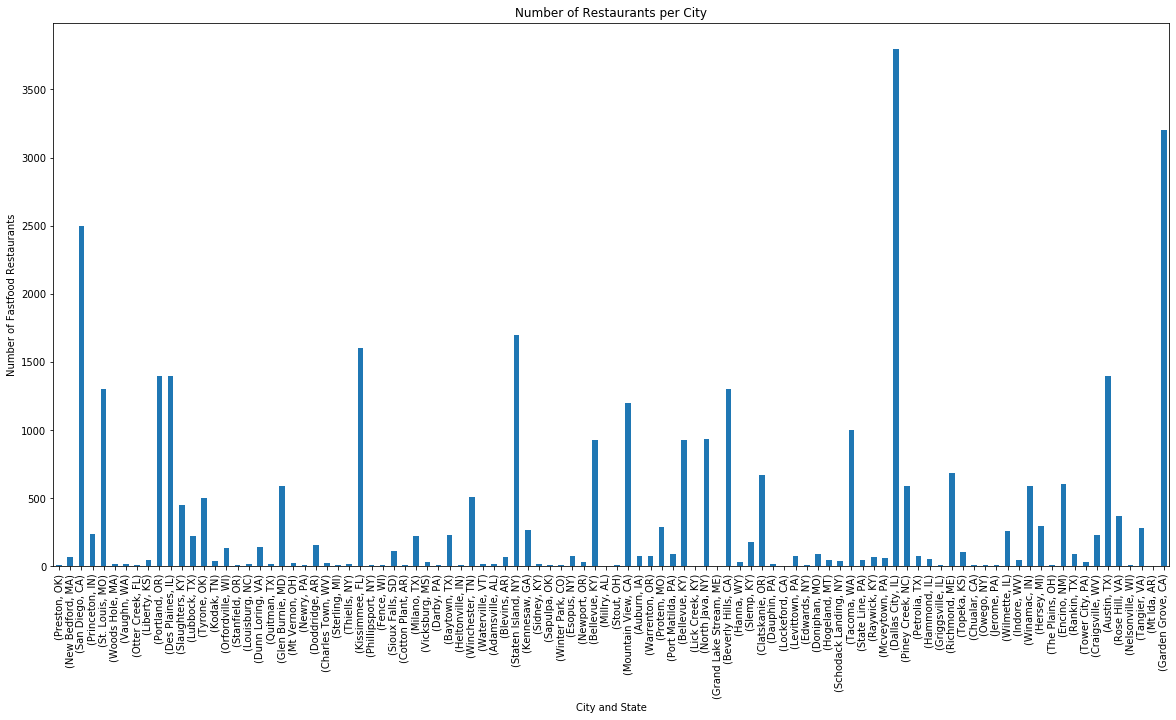

In [9]:
#Create Bar graph of number of restaurants per city
total_fastfood_city_df_index_city=total_fastfood_city_df.set_index(['City', 'State'])
total_fastfood_city_df_index_city["Number of Fast Food"].plot(kind="bar", figsize=(20,10))
plt.xlabel("City and State")
plt.ylabel("Number of Fastfood Restaurants")
plt.title("Number of Restaurants per City")
#plt.show()
plt.savefig("../output/NumberOfRestaurantsPerCity.png")

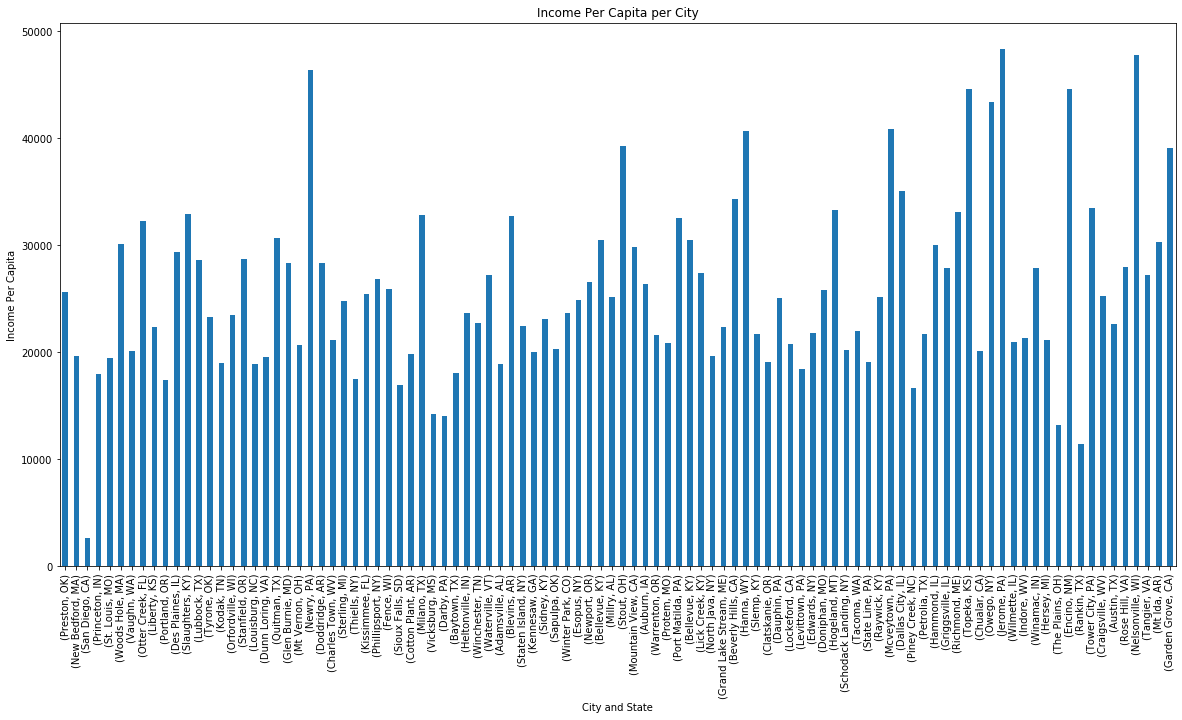

In [10]:
total_fastfood_city_df_index_city["Income Per Capita"].plot(kind="bar", figsize=(20,10))
plt.xlabel("City and State")
plt.ylabel("Income Per Capita")
plt.title("Income Per Capita per City")
#plt.show()
plt.savefig("../output/IncomePerCapitaPerCity.png")

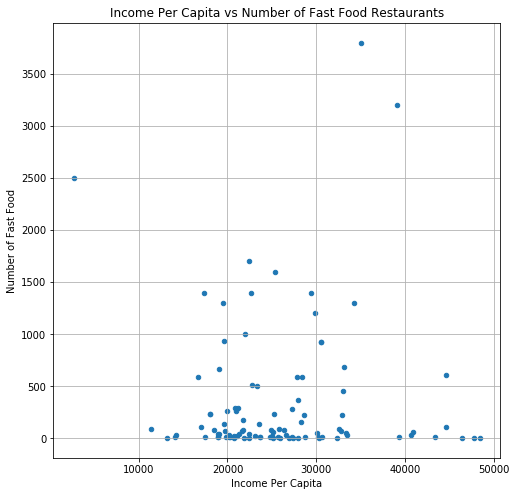

In [11]:
total_fastfood_city_df_index_city.plot(kind='scatter', x = 'Income Per Capita', y = 'Number of Fast Food', grid = True, figsize=(8,8))
plt.title("Income Per Capita vs Number of Fast Food Restaurants")
#plt.show()
plt.savefig("../output/IncomePerCapitaVSnumberOfFastFood.png")

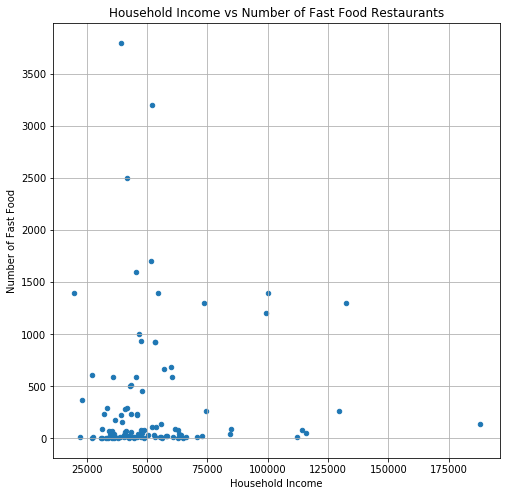

In [12]:
total_fastfood_city_df_index_city["Household Income"] = total_fastfood_city_df_index_city["Household Income"].astype(int)
total_fastfood_city_df_index_city.plot(kind='scatter', x = 'Household Income', y = 'Number of Fast Food', grid = True, figsize=(8,8))
plt.title("Household Income vs Number of Fast Food Restaurants")
#plt.show()
plt.savefig("../output/householdIncomeVSnumberOfFastFood.png")

In [13]:
#Calculate the IQR and quantitatively determine if there are any potential outliers. 
house_income =total_fastfood_city_df['Household Income'].astype(int)

quartiles = house_income.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of Household Income is: {lowerq}")
print(f"The upper quartile of Household Income is: {upperq}")
print(f"The interquartile range of Household Income is: {iqr}")
print(f"The the median of Household Income is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

outlier_ff = total_fastfood_city_df.loc[(house_income < lower_bound) | (house_income > upper_bound)]
outlier_ff

The lower quartile of Household Income is: 39349.0
The upper quartile of Household Income is: 58065.25
The interquartile range of Household Income is: 18716.25
The the median of Household Income is: 46080.5 
Values below 11274.625 could be outliers.
Values above 86139.625 could be outliers.


,State,City,Number of Fast Food,Income Per Capita,Household Income,Lat,Lng
9,OR,Portland,1400,17399.0,100063,45.5593978,-122.807445
18,VA,Dunn Loring,140,19556.0,187768,38.8934705,-77.2203966
26,NY,Thiells,14,17493.0,112016,41.2099325,-74.0153231
46,NY,Esopus,76,24929.0,114129,41.8214302,-73.9624327
51,CA,Mountain View,1200,29853.0,99375,37.3785351,-122.086585
60,CA,Beverly Hills,1300,34293.0,132254,6.5858886,100.9354944
69,MT,Hogeland,48,33301.0,115938,48.7645002,-108.7498486
85,IL,Wilmette,262,20989.0,129551,42.0805743,-87.7320368


In [14]:
gmaps.configure(api_key=gkey)

locations = total_fastfood_city_df[["Lat", "Lng"]].astype(float)
total_restaurants = total_fastfood_city_df["Number of Fast Food"].astype(float)

fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=total_restaurants, dissipating=False, max_intensity=65,
                                 point_radius = 0.5)
fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

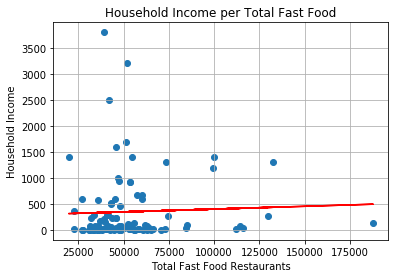

In [15]:
x_axis = total_fastfood_city_df["Household Income"].astype(int)
y_axis = total_fastfood_city_df["Number of Fast Food"].astype(int)
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_axis, y_axis)
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(5,10),fontsize=10,color="red")
plt.title("Household Income per Total Fast Food")
plt.xlabel("Total Fast Food Restaurants")
plt.ylabel("Household Income")
plt.grid(True)
#plt.show()
plt.savefig("../output/HouseholdIncomePerTotalFastFood.png")

In [16]:
house_hold_income = total_fastfood_city_df["Household Income"].astype(int)
TotalFastFood = total_fastfood_city_df["Number of Fast Food"].astype(int)
print(f"The correlation coefficient between Household Income and Total Fast Food Restaurants is {round(st.pearsonr(house_hold_income,TotalFastFood)[0],2)}")
print(f"The P-Value between Household Income and Total Fast Food Restaurants is {round(st.pearsonr(house_hold_income,TotalFastFood)[1],2)}")

The correlation coefficient between Household Income and Total Fast Food Restaurants is 0.04
The P-Value between Household Income and Total Fast Food Restaurants is 0.68
